# Geosilhouettes：集群拟合的地理测量

[Silhouette statistics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html) (<a href="https://doi.org/10.1016/0377-0427(87)90125-7">Rousseeuw, 1987</a>)  是观测值与给定聚类的拟合优度的非参数度量。 在聚类具有“地理”解释的情况下，例如当它们代表地理区域时，轮廓统计可以结合“空间思维”，以便提供更有用的聚类拟合度量。 [Wolf、Knaap 和 Rey 的论文 (2019)](https://doi.org/10.1177%2F2399808319875752)。
([SocArXiv 上的预印本](https://osf.io/preprints/socarxiv/vd3uk/)) 定义了两个：

1. **路径轮廓**，表征聚类中的联合地理和特征相似性。
2. **边界轮廓**，表征集群中地理边界的明确程度。

这两项新措施共同提供了测量地理数据科学中聚类问题中聚类拟合优度的新方法。

下面，我们将深入探讨这些是如何在“esda”包中实现的。 首先，让我们设置一些数据。 我们将考虑单个*单变量*数据集，即 1989 年美国南部腹地各县的基尼指数。

In [27]:
import libpysal
import numpy
import esda
import geopandas
import contextily
import matplotlib.pyplot as plt
%matplotlib inline

为了只关注南方腹地，我们将建立一系列位于南方腹地的州：

In [28]:
focus_states = ["Alabama", "Georgia", "Louisiana", 
                "Mississippi", "South Carolina"]

然后，我们将使用“libpysal”包中的示例数据集读取所有南部地区的数据：

In [29]:
south = libpysal.examples.example_manager.load('South')

In [30]:
south = geopandas.read_file(libpysal.examples.get_path('south.shp'))

然后，我们将仅过滤掉南部腹地的州：

In [31]:
deep = south.query('STATE_NAME in @focus_states').reset_index()

In [32]:
deep['state_label'] = deep.STATE_NAME.apply(lambda x: focus_states.index(x))

最后，出于绘图目的，让我们获取底图。 这是使用“contextily”包完成的，该包期望我们的数据位于特定的坐标投影系统中。 有关更多信息，请查看 [`contextily` 用户指南](https://github.com/darribas/contextily/blob/master/contextily_guide.ipynb)。

In [33]:
deep.crs = {'init':'epsg:4326'}

d:\work\miniconda3\envs\esda\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [34]:
deep = deep.to_crs(epsg=3857)

In [36]:
basemap, extent = contextily.bounds2img(*deep.total_bounds, zoom=6,
                                        source=contextily.providers.Stamen.TonerLite)

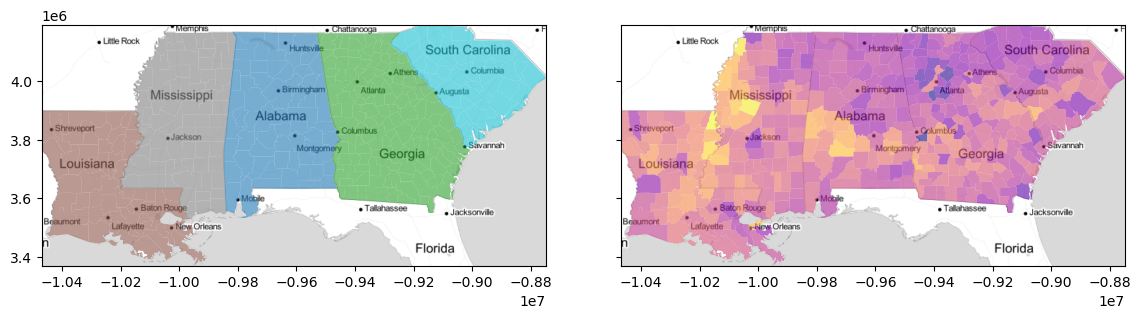

In [37]:
f,ax = plt.subplots(1,2, figsize=(12,3), sharex=True, sharey=True)
deep.plot('STATE_NAME', ax=ax[0], alpha=.6)
deep.plot('GI89', ax=ax[1], cmap='plasma', alpha=.6)
for ax_ in ax:
    ax_.imshow(basemap, extent=extent, interpolation='bilinear')
    ax_.axis(deep.total_bounds[[0,2,1,3]])
f.tight_layout()
plt.show()

# The Silhouette Score

在分类/分组问题中使用的标准轮廓分数，用于衡量观察结果与其当前组的拟合程度。 该措施相当稳健，经过充分研究，并且在许多不同的问题领域都很常见。

从统计上来说，轮廓得分由以下几个部分组成：
- $c$，分配$i$的簇
- $k$，另一个当前未分配 $i$ 的簇
- $d_i(c)$：观察值 $i$ 和 $i$ 自己的聚类 $c$ 之间的差异
- $d_i(k)$：观察值 $i$ 与 $i$ 不在的聚类 $k$ 之间的差异。

在这里，我们将 $d$ 定义为任意相异度度量。 对于大多数情况，通常是欧氏距离。 因此，如果您看到 $d_i(c)$，则这是观察值 $i$ 与集群 $c$ 中所有其他观察值 $j$ 之间的平均差异。

然后，我们需要定义*第二最佳选择簇*，$\hat{k}$，它是与 $i$ 最相似的簇，但 $i$ 当前不是其中的成员：
$$\hat{k}_i = k\ | \min_k \{d_i(k)\}$$

这让我们将轮廓分数定义为 $i$ 与其聚类 $c$ 以及 $i$ 与第二最佳选择聚类 $\hat{k}$ 的相异性分数之间的关系：
$$ s_i = \frac{d_i(c) - d_i(\hat{k})}{\max\left\{d_i(c), d_i(\hat{k})\right\}}$$

当 $i$ 比第二佳聚类 $\hat{k}$ 更接近其当前聚类 $c$ 时，该值接近 1，表明与其当前聚类的强拟合。 并且，当 $i$ 与 $\hat{k}$ 比与其自己的簇 $c$ 更相似时，$s_i$ 的值接近 -1。 我们可以使用“sklearn”的“silhouette_samples”计算每个观察的分数：

In [38]:
from sklearn.metrics import silhouette_samples
silhouettes = silhouette_samples(deep[['GI89']].values, deep.state_label)

在这里，我们可以按县可视化轮廓得分。 通过这些信息，我们可以看到*内*州的基尼系数存在很强的异质性，因为每个县的轮廓统计通常为负（即蓝色）。 但是，在某些地区（例如南卡罗来纳州和路易斯安那州的地区），县的轮廓统计数据为正（红色），表明这些县与其周围环境非常契合。

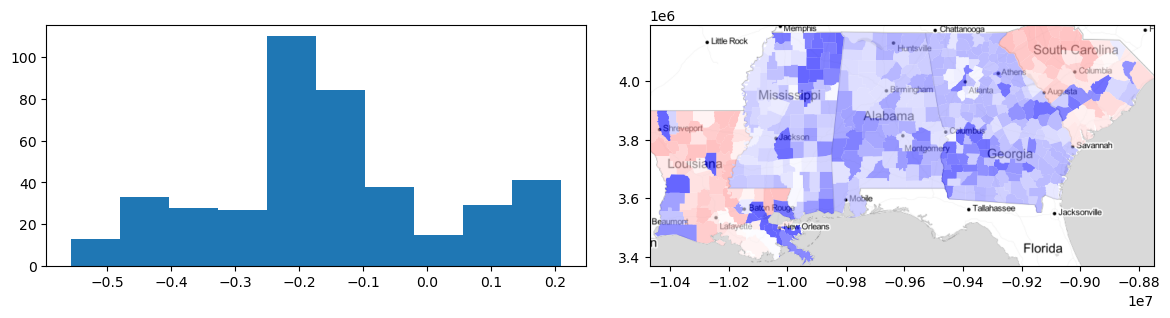

In [39]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(silhouettes)
deep.plot(silhouettes, ax=ax[1], cmap='bwr', 
          vmin=-.5, vmax=.5, alpha=.6)
ax[1].imshow(basemap, extent=extent, interpolation='bilinear')
ax[1].axis(deep.total_bounds[[0,2,1,3]])
f.tight_layout()
plt.show()

相反，如果我们使用“数据驱动”的区域定义，我们可能会期望轮廓分数更加积极。 例如，如果我们使用 $k$-means 来定义该数据的*最佳*数据驱动组，我们可能会得到如下结果：

In [40]:
from sklearn.cluster import KMeans
data_driven_clustering = KMeans(n_clusters=len(focus_states)).fit(deep[['GI89']].values)
data_labels = data_driven_clustering.labels_
data_silhouettes = silhouette_samples(deep[['GI89']].values, 
                                      data_labels)

d:\work\miniconda3\envs\esda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\work\miniconda3\envs\esda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


这就产生了以下南方腹地不平等的地理分布：

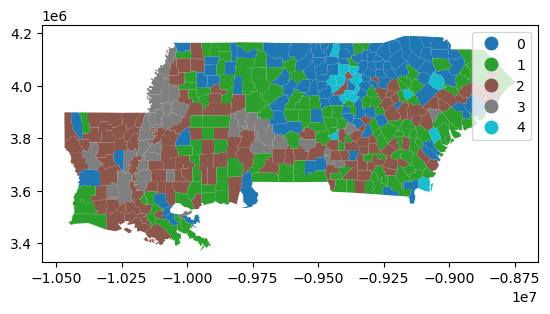

In [41]:
deep.plot(data_labels, categorical=True, legend=True)
plt.show()

而且，在这种不平等的地理环境中，每个县都非常适合其群体：

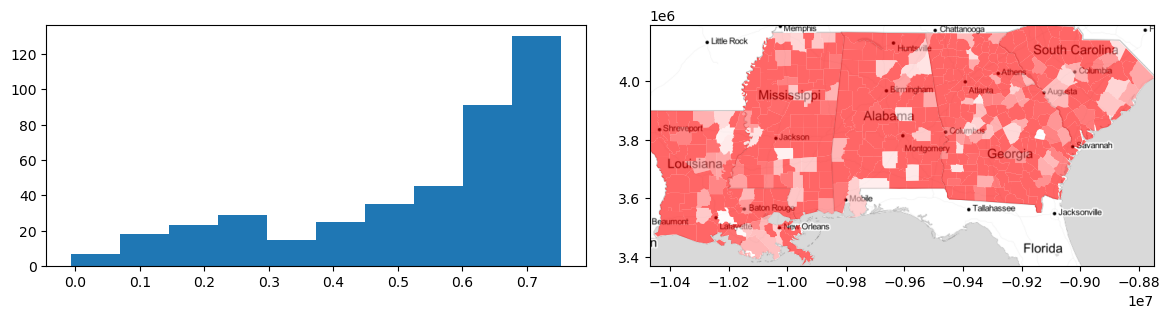

In [42]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(data_silhouettes)
deep.plot(data_silhouettes, ax=ax[1], cmap='bwr', 
          vmin=-.5, vmax=.5, alpha=.6)
ax[1].imshow(basemap, extent=extent, interpolation='bilinear')
ax[1].axis(deep.total_bounds[[0,2,1,3]])
f.tight_layout()
plt.show()

# Nearest Label

测量轮廓分数的基础是“下一个最佳拟合簇”的想法。 这是 $\hat{k}_i$，如果 $i$ 不在其当前簇 $c$ 中，*将*被分配到该簇。 这是一个有用的概念，因为它显示了观测值与其他聚类之间的潜在关系。 它了解如果做出了关于分组/分类的不同决策，聚类*可能*会有什么不同，并帮助我们构建一个衡量标准，衡量当前 $c$ 对于 $i$ 比 $\hat{k} “更好”多少 _i$ 会是。

但是，默认情况下，`scikit-learn` 不会为您提供 $\hat{k}_i$。 相反，它只提供$s_i$。 因此，“esda”在“nearest_label”函数中为您提供了这一点：

In [43]:
nearest_label = esda.silhouettes.nearest_label(deep[['GI89']].values, deep.state_label)

通过此函数，您可以可视化*第二最佳选择*$\hat{k}_i$ 的地理位置。 例如，阿拉巴马州和佐治亚州南部的大部分地区以及[密西西比三角洲地区](https://en.wikipedia.org/wiki/Mississippi_Delta)与路易斯安那州的不平等状况具有“第二选择”相似性。 这意味着，如果这些县*不在*自己的州内，它们将与路易斯安那州的县最相似。

但是，请记住，“第二选择”的想法将 $c_i$ 从*最近标签*的潜在列表中排除！

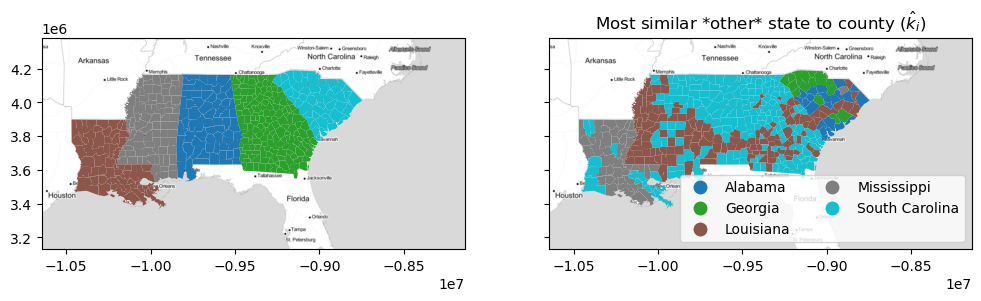

In [44]:
nearest_outside_state = numpy.asarray(focus_states)[nearest_label]
f, ax = plt.subplots(1,2,figsize=(12,4), sharex=True, sharey=True)
deep.plot('STATE_NAME', ax=ax[0], categorical=True)
deep.plot(nearest_outside_state, ax=ax[1],
               legend=True, categorical=True, 
               legend_kwds=dict(loc='lower right', ncol=2))
ax[1].set_title('Most similar *other* state to county ($\hat{k}_i$)')
for ax_ in ax:
    ax_.imshow(basemap, extent=extent, interpolation='bilinear')

为了实现这一点，“keep_self”参数修改“nearest_label”以返回*任何*组中最近的标签，无论观察当前是否位于该组中。 这意味着*最近的替代标签*由`nearest_label`提供，但*绝对最近的标签*由`nearest_label(data, labels, keep_self=True)`提供。

这两者可能完全不同。 下面，您可以看到，当我们允许观测值的最近标签作为其“当前”分类时，相似性肯定会发生变化。 在那里，我们看到大多数县要么与路易斯安那州更相似，要么与南卡罗来纳州更相似。 强制返回“最近的替代标签”导致密西西比州成为路易斯安那州大多数县的第二选择，而阿拉巴马州和佐治亚州则成为南卡罗来纳州许多县的第二选择。

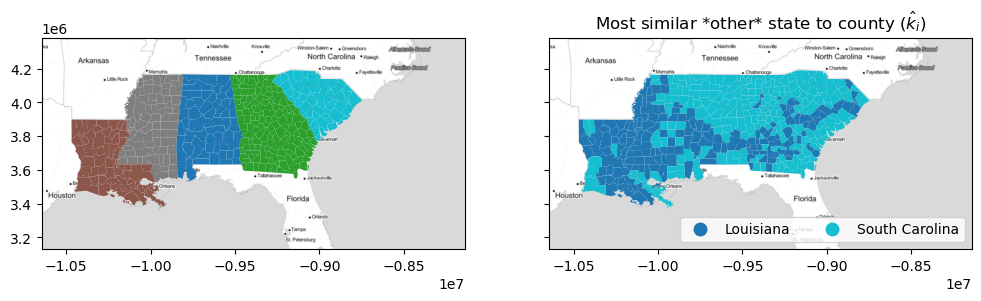

In [45]:
nearest_label = esda.silhouettes.nearest_label(deep[['GI89']].values, 
                                   deep.state_label, keep_self=True)
nearest_state = numpy.asarray(focus_states)[nearest_label]
f, ax = plt.subplots(1,2,figsize=(12,4), sharex=True, sharey=True)
deep.plot('STATE_NAME', ax=ax[0], categorical=True)
deep.plot(nearest_state, ax=ax[1],
               legend=True, categorical=True, 
               legend_kwds=dict(loc='lower right', ncol=2))
ax[1].set_title('Most similar *other* state to county ($\hat{k}_i$)')
for ax_ in ax:
    ax_.imshow(basemap, extent=extent, interpolation='bilinear')

# Geographical Structure

对于许多地理分析算法，我们需要一定的地理结构意识才能“理解”地理。 在最基本的层面上，这要求我们定义可用于分析的地理表示。 通常，这采用[*图表*或*网络*](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics))的形式，链接观察结果。 在这种分析模式中，每个*节点*都是一个观测值，每个*边*代表观测值之间的地理连接。

`pysal`/`libpysal` 库包含许多用于从地理数据构建图形的工具。 在这些领域中，通常将地理图的一种表示称为“空间权重矩阵”，因为它反映了每个观测值相对于其他观测值的“空间权重”。 因此，它存储在“libpysal.weights”模块中。

在这里，我们将构建 [Rook 连续性图](https://gis.stackexchange.com/questions/172998/queen-vs-rook-neighborhood)（有时称为 [von Neuman 邻域](https://en .wikipedia.org/wiki/Von_Neumann_neighborhood)) 使用 `libpysal.weights.Rook` 构造函数的县：

In [46]:
w = libpysal.weights.Rook.from_dataframe(deep)

为了看看它是什么样子，我们可以绘制下面的图表，其中“连接”县的中心之间画有一条黑线：

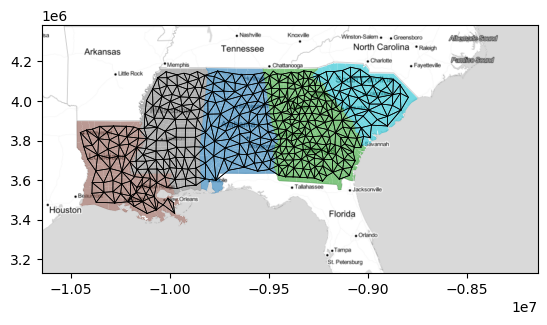

In [47]:
f,ax = w.plot(deep, edge_kws=dict(linewidth=.5), 
              node_kws=dict(s=0))
deep.plot('STATE_NAME', ax=ax, alpha=.6)
ax.imshow(basemap, extent=extent, interpolation='bilinear')
plt.show()

# Path Silhouettes

路径轮廓将两个观测值之间的联合地理和特征差异建模为“联合”空间和社会相似性：

$$ d(i,j) = d_f(i,j) * d_s(i,j)$$

其中 $d_f(i,j)$ 是观测值 $i$ 和 $j$ 的*特征*之间的差异，$d_s(i,j)$ 是站点 $i$ 和 $j$ 之间的*空间*差异 。 通常，$d_s(i,j)$ 通过所有站点对之间的欧几里得距离矩阵来测量，但这有时可能包括有关某些类型空间数据的距离的不准确或错误表示的信息。 因此，*path* 轮廓使用 $d_s$ 来计算连接 $i$ 和 $j$ 的 *path* 的总成对差异性。

对于全距离矩阵，站点 $i$ 和 $j$ 之间的路径差异简单地简化为站点 $i$ 和 $j$ 之间的差异乘以站点 $i$ 和 $j$ 之间的差异。 当 $d_s$ 不是*全距离矩阵时，$d_f(i,j) * d_s(i,j)$ 被建模为连接站点 $i$ 和 $j$ 的最短路径的长度。 该路径可能包括“其他”中间站点，因此整个路径成本是从 $i$ 到 $j$ 的最短路径上的链接的“总和”。 例如，如果从 $i$ 到 $j$ 的最短路径是从附加链接 $i \rightarrow l \rightarrow m \rightarrow j$ 构建的，则表示 $d(i,j)$ 的路径成本为：

$$ d(i,j) = d_f(i,l) * d_s(i,l) + d_f(l,m) * d_s(l,m) + d_f(m,j) * d_s(m,j) $$

这种“路径度量”在地理分析问题中很常见，但提供了对观测值和组的联合地理特征相似性的有用见解。 然后，使用这个 $d$，以相同的方式计算剪影。

在“esda”中，这是使用我们之前构建的空间权重对象以及我们之前用于经典轮廓的相同数据和标签来完成的：

In [21]:
path_silhouette = esda.path_silhouette(deep[['GI89']].values, 
                                       deep.state_label, w)

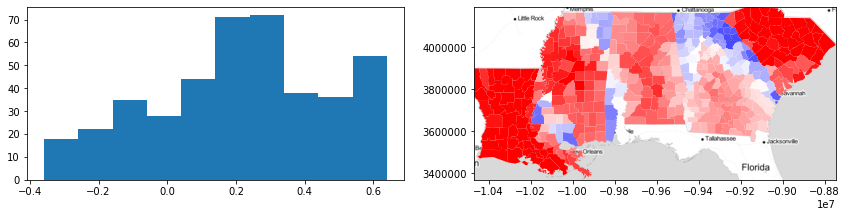

In [22]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(path_silhouette)
deep.plot(path_silhouette, ax=ax[1], cmap='bwr', vmin=-.5, vmax=.5)
ax[1].imshow(basemap, extent=extent, interpolation='bilinear')
ax[1].axis(deep.total_bounds[[0,2,1,3]])
f.tight_layout()
plt.show()

由此，我们看到“大多数”路径轮廓是积极的，但有些（特别是在相似状态之间的边界上）是消极的。 此外，我们看到传统剪影分析中出现的两个州（路易斯安那州和南卡罗来纳州）“再次”具有强烈的路径相似性，这意味着它们在地理上都具有独特性，并且在不平等状况上是同质的。

`path_silhouette` 函数提供了许多额外的输出，但一个有用的输出提供了与 `nearest_label` 等效的路径：路径度量下的下一个最适合的集群。 要访问此功能，请将“return_nbfc=True”传递给“path_silhouette”函数：

In [23]:
path_silhouette, next_best_path = esda.path_silhouette(deep[['GI89']].values, 
                                                       deep.state_label, w, 
                                                       return_nbfc=True)

直观地，我们看到“路径”相似性可以在第二选择聚类图中强化强大的空间结构。 例如，“最终”州（路易斯安那州和南卡罗来纳州）除了距离最近的州外基本上别无选择。 但是，中间的三个州在它们的邻居之间被整齐地分成两半。

然而，这些在剪影图中结合在一起，在联合地理和特征相似性方面产生了相当显着的模式！ 这些模式并不严格遵循边界。 事实上，佐治亚州北部的负路径轮廓（主要是由亚特兰大-雅典郊区的相似性驱动）和正区域完全忽略了路径相似地图中的划分。 这表明这种相似性在地理上会平滑变化，即使“参考”类别不会变化。

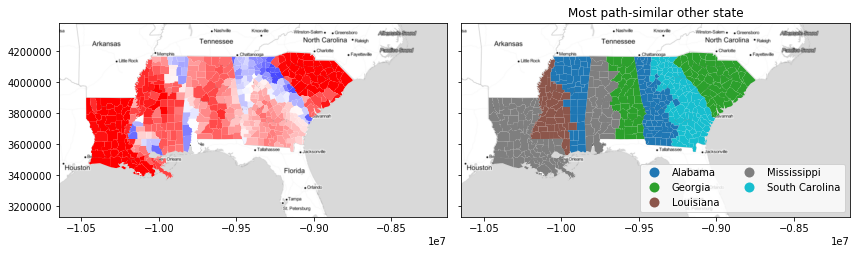

In [24]:
next_best_path_state = numpy.asarray(focus_states)[next_best_path]
f, ax = plt.subplots(1,2,figsize=(12,4), sharex=True, sharey=True)
deep.plot(path_silhouette, ax=ax[0], cmap='bwr', vmin=-.5, vmax=.5)
deep.plot(next_best_path_state, ax=ax[1],
               legend=True, categorical=True, 
               legend_kwds=dict(loc='lower right', ncol=2))
ax[1].set_title('Most path-similar other state')
for ax_ in ax:
    ax_.imshow(basemap, extent=extent, interpolation='bilinear')
f.tight_layout()
plt.show()

# Boundary Silhouettes

使用剪影统计对地理相似性的最终测量限制了剪影“第二选择”集群，使其具有地理“意义”。 由此，再次考虑经典轮廓中的第二选择簇的图：

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


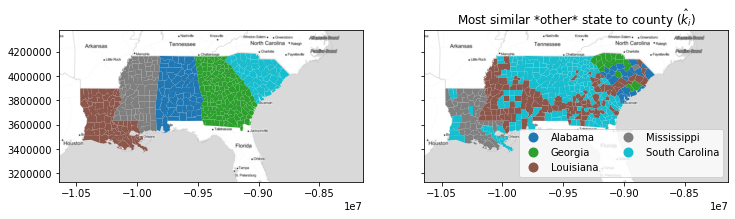

In [25]:
nearest_label = esda.nearest_label(deep[['GI89']].values, deep.state_label)
nearest_outside_state = numpy.asarray(focus_states)[nearest_label]
f, ax = plt.subplots(1,2,figsize=(12,4), sharex=True, sharey=True)
deep.plot('STATE_NAME', ax=ax[0], categorical=True)
deep.plot(nearest_outside_state, ax=ax[1],
               legend=True, categorical=True, 
               legend_kwds=dict(loc='lower right', ncol=2))
ax[1].set_title('Most similar *other* state to county ($\hat{k}_i$)')
for ax_ in ax:
    ax_.imshow(basemap, extent=extent, interpolation='bilinear')

这种情况下，南卡罗来纳州有很多县的“第二选择”就完全是路易斯安那州了！ 这是不现实的，因为这些观察结果在地理意义上并不能真正合理地与路易斯安那州的县归为一类。 考虑到这一点，我们将注意力仅限于具有“可行”第二选择的县，这意味着它们可以“翻转”到另一组而不会变得孤立。

这会自动将我们的注意力限制在“边境”县，即那些与另一个州接触的县。 对于边界轮廓，所有“内部”观察（那些“不”接触另一组中的观察的观察）的边界轮廓的默认值为零。 所有其他人都将 $\hat{k}_i$ 限制为地理上 $i$ *接近*的集群。 有了这个约束，轮廓的其余部分就可以正常计算。

为了展示它的样子，我们可以使用 `esda.boundary_silhouette` 函数：

In [26]:
boundary_silhouette = esda.boundary_silhouette(deep[['GI89']].values, 
                                               deep.state_label, w)
deep['boundary_silhouette'] = boundary_silhouette

为此，“绝大多数”的观察结果不在州之间的边界上，因此大多数边界轮廓为零：

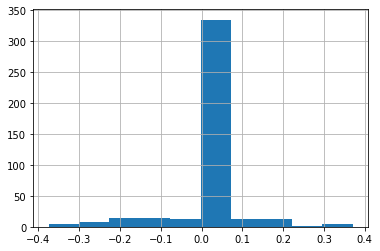

In [27]:
deep.boundary_silhouette.hist()

因此，将这些“结构”零点与“实际”边界上的观察结果分开考虑通常是有意义的：

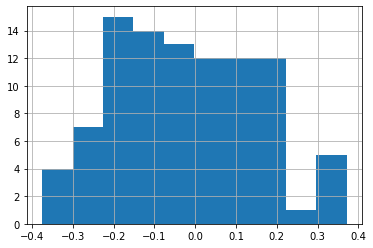

In [28]:
deep.query('boundary_silhouette != 0').boundary_silhouette.hist()

当“边界”县与“边界另一侧”的州比与自己的州更相似时，这些观察结果是负面的。 当一个县与自己的州比边界另一侧的另一个州更相似时，它们是积极的。

可视化这个轮廓，有助于再次分离出零：

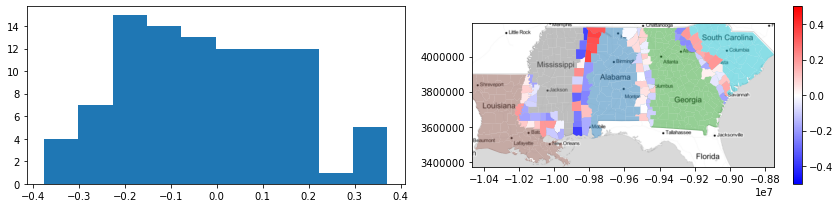

In [29]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(deep.query('boundary_silhouette != 0').boundary_silhouette)
deep.plot('STATE_NAME', ax=ax[1], alpha=.5)
deep.query('boundary_silhouette != 0')\
    .plot('boundary_silhouette', ax=ax[1], cmap='bwr', 
          vmin=-.5, vmax=.5, legend=True)
ax[1].imshow(basemap, extent=extent, interpolation='bilinear')
ax[1].axis(deep.total_bounds[[0,2,1,3]])
f.tight_layout()
plt.show()

从中，您可以看到以下内容：
- 密西西比州和路易斯安那州边境的所有地区的基尼值都与路易斯安那州的地区相似。
- 阿拉巴马州北部和南部与密西西比州的相似之处存在显着差异； 在北部，边界地区比南部更像“阿拉巴曼”。
- 阿拉巴马州和佐治亚州之间的边界相当薄弱； 大多数剪影都非常接近于零，这表明该地区的差异是相当渐进的，并且两者之间的边界地区与阿拉巴马州或佐治亚州非常相似。

# Conclusion

总体而言，轮廓统计在聚类和相似性分析中很有用。 然而，在地理应用中，除了轮廓统计探索的特征结构之外，了解群体的“地理”结构有时也变得很重要。 因此，Wolf、Knaap 和 Rey (2019) 提出了两个新的轮廓统计数据：

1. 路径轮廓，衡量关节特征和地理相似性。
2. 边界轮廓，衡量群体之间“边界”的相似度。

两者都有不同的用途，并且不会取代轮廓统计数据。 相反，它们是空间补充，提供有关聚类问题中群体地理结构的不同信息。